In [1]:
import sys
sys.path.append('..')
import gluonbook as gb
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n_train = 20
n_test = 100
num_inputs = 200
true_w = nd.ones((num_inputs, 1)) * 0.01
true_b = 0.05

features = nd.random.normal(shape=(n_train+n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

num_epochs = 10
learning_rate = 0.003
batch_size = 1
train_iter = gdata.DataLoader(gdata.ArrayDataset(
    train_features, train_labels), batch_size, shuffle=True)
loss = gloss.L2Loss()

In [3]:
def fit_and_plot(weight_decay):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=1))
    # 对权重参数做 L2 范数正则化，即权重衰减。
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    # 不对偏差参数做 L2 范数正则化。
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', {
        'learning_rate': learning_rate})
    train_ls = []
    test_ls = []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # 对两个 Trainer 实例分别调用 step 函数。
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features),
                             train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features),
                            test_labels).mean().asscalar())
    gb.semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss',
                range(1, num_epochs+1), test_ls, ['train', 'test'])
    return 'w[:10]:', net[0].weight.data()[:,:10], 'b:', net[0].bias.data()

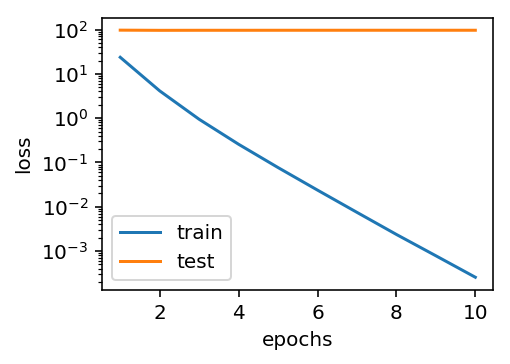

('w[:10]:', 
 [[ 0.30306962 -0.08118342  0.6478718  -1.5161407   0.16547368  0.4210665
    0.41199407  0.8322212  -0.6647298   3.562562  ]]
 <NDArray 1x10 @cpu(0)>, 'b:', 
 [0.12501878]
 <NDArray 1 @cpu(0)>)

In [4]:
fit_and_plot(0)

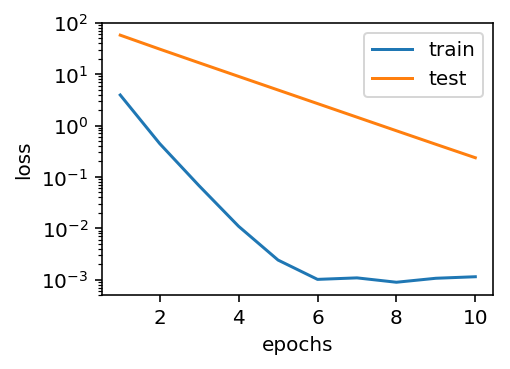

('w[:10]:', 
 [[ 0.07438846  0.0403108  -0.07616828 -0.00911447 -0.05812658  0.04108042
    0.09271767 -0.04897385  0.02549439 -0.03707352]]
 <NDArray 1x10 @cpu(0)>, 'b:', 
 [0.11307331]
 <NDArray 1 @cpu(0)>)

In [5]:
fit_and_plot(5)